## 现在来做经验数据的相关性分析

In [14]:
# 做各个变量的时序上的相关性分析

# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# 加载经验数据
print("Loading empirical data...")
w_media_empirical = pd.read_csv('./new_output/empirical/w_media_risk_data_7days.csv')
o_people_empirical = pd.read_csv('./new_output/empirical/sentiment_data_7days.csv')
m_media_empirical = pd.read_csv('./new_output/empirical/m_media_risk_data_7days.csv')

# 创建经验数据字典
emp_w_risk_p = dict(zip(w_media_empirical['period_id_3d'], w_media_empirical['risk_p']))
emp_m_risk_p = dict(zip(m_media_empirical['period_id_3d'], m_media_empirical['risk_p']))
emp_sentiment_high_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['high_p']))
emp_sentiment_middle_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['middle_p']))
emp_sentiment_low_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['low_p']))


Loading empirical data...


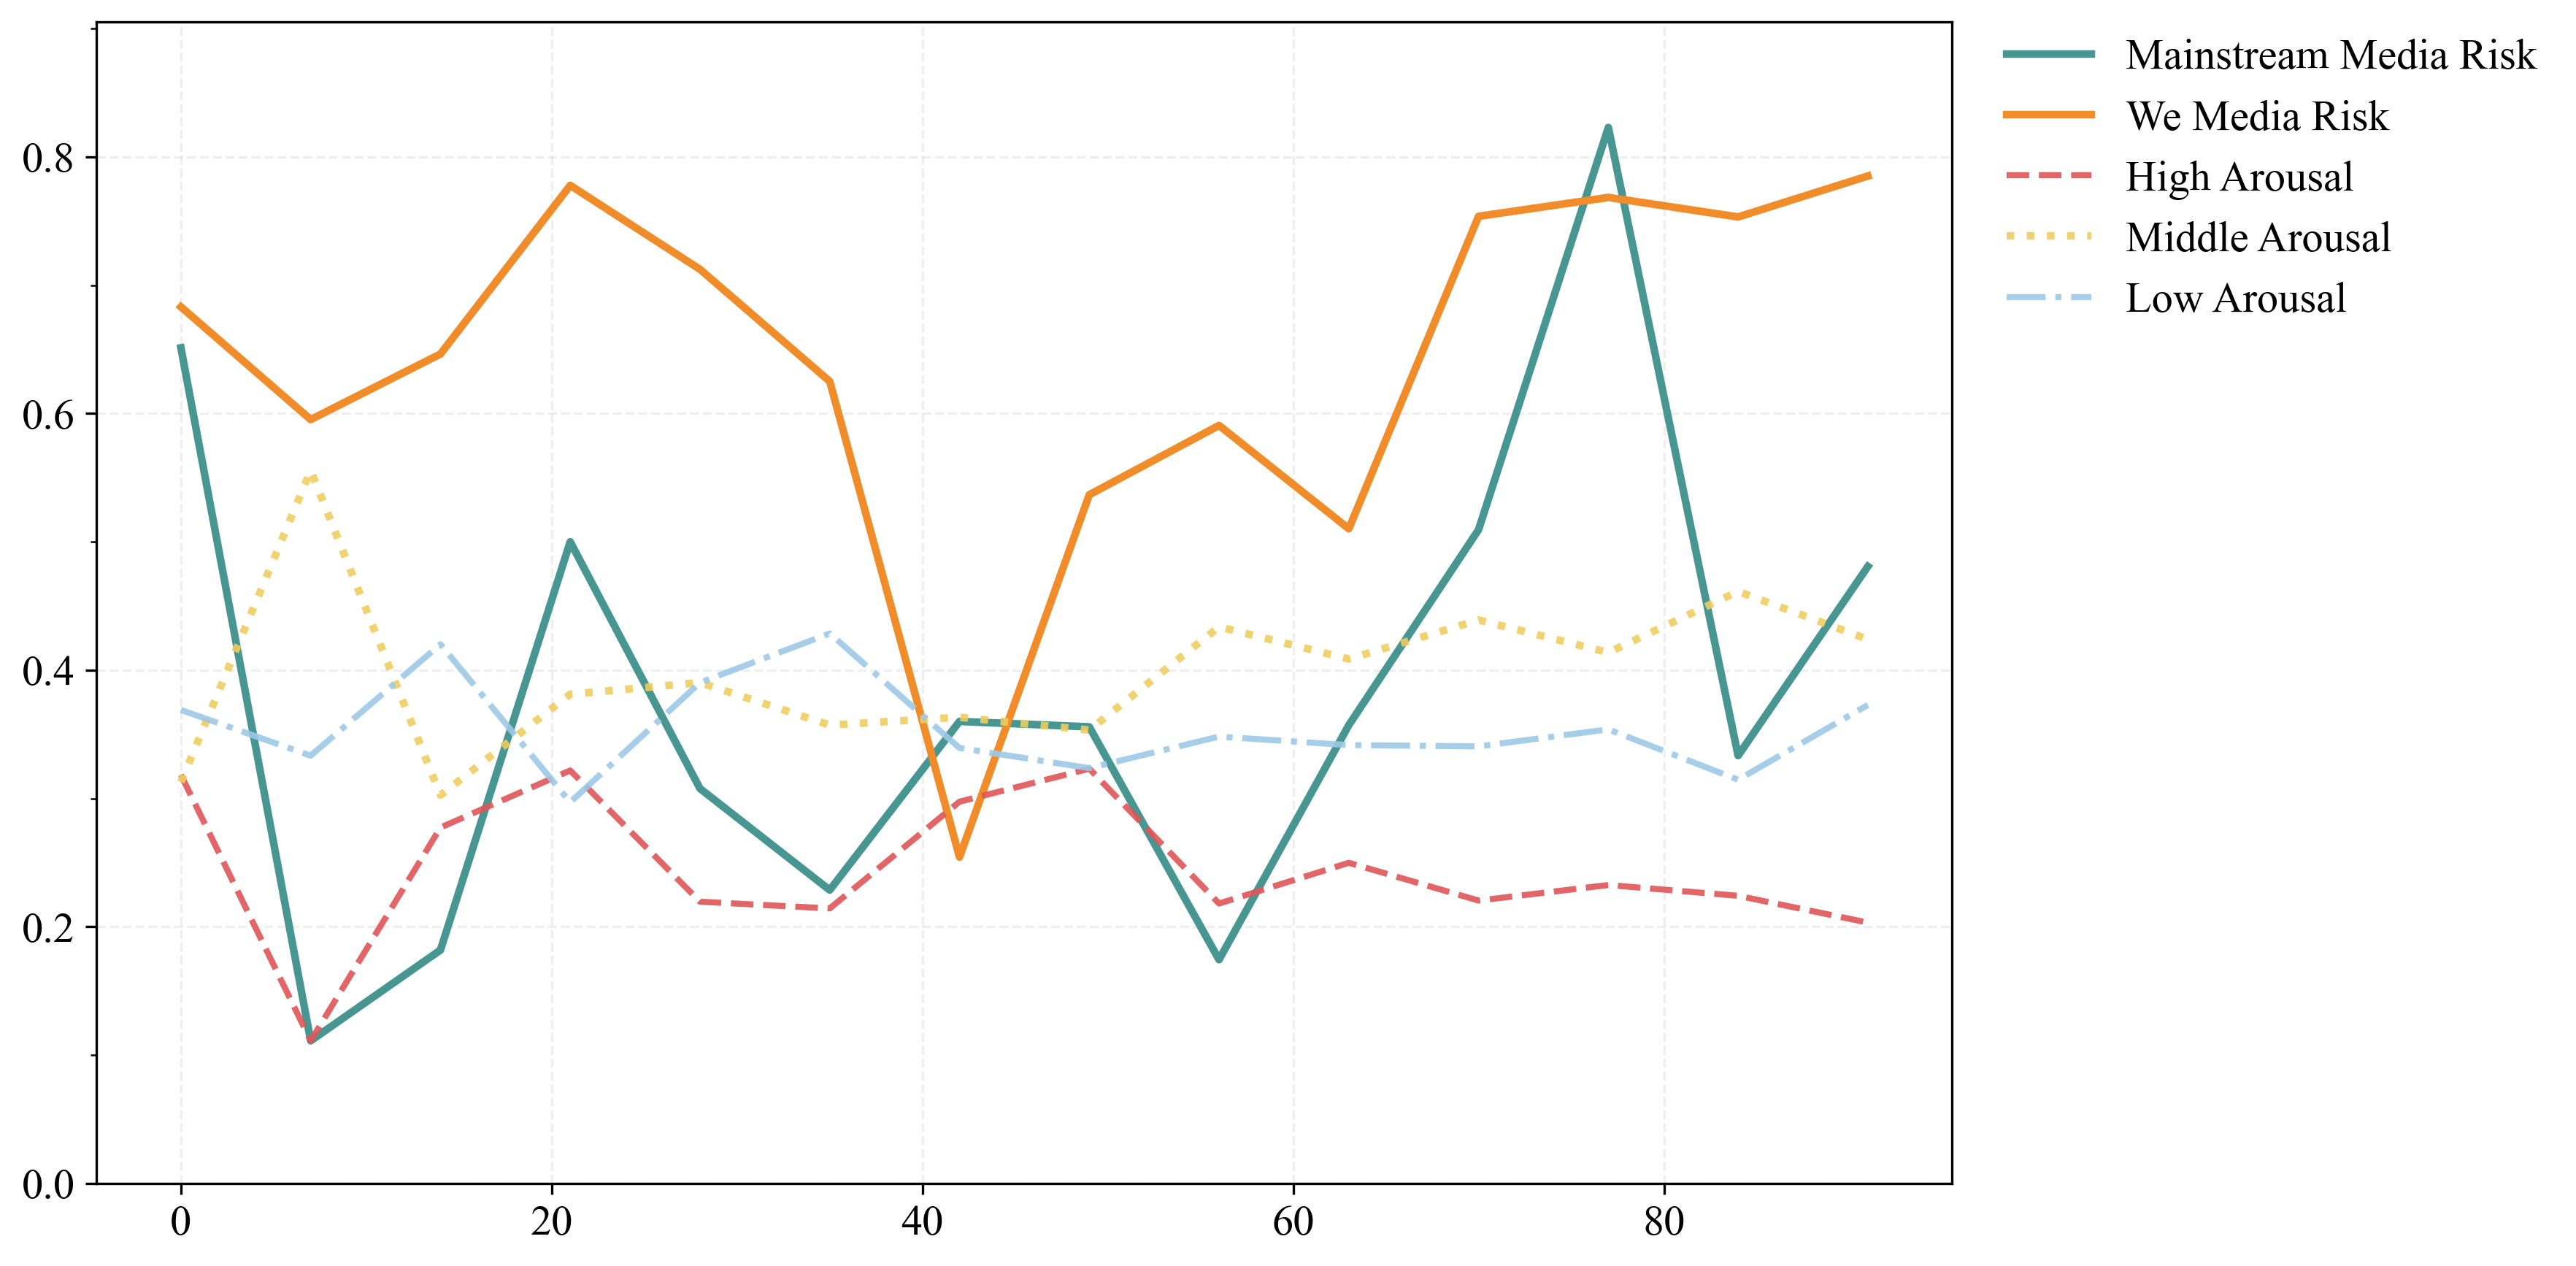

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 设置字体大小
plt.rcParams['font.size'] = 14

# 创建时间序列数据框并转换索引为天数
ts_data = pd.DataFrame({
    'M_R': pd.Series(emp_m_risk_p),
    'W_R': pd.Series(emp_w_risk_p),
    'S_H': pd.Series(emp_sentiment_high_p),
    'S_M': pd.Series(emp_sentiment_middle_p),
    'S_L': pd.Series(emp_sentiment_low_p)
})

# 将周数索引转换为天数索引
ts_data.index = ts_data.index * 7  # 将周转换为天

# 定义Nature风格的颜色方案
colors = {
    'M_R': '#479692',  # 青绿色
    'W_R': '#F08D2A',  # 橙色
    'S_H': '#DF5557',  # 红色
    'S_M': '#EFCD61',  # 黄色
    'S_L': '#9EC9E7'   # 蓝色
}

# 创建更好的标签映射
labels = {
    'M_R': 'Mainstream Media Risk',
    'W_R': 'We Media Risk',
    'S_H': 'High Arousal',
    'S_M': 'Middle Arousal',
    'S_L': 'Low Arousal'
}


# 调整图形大小，加宽以减少重叠
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# 定义线条样式，增加区分度
line_styles = {
    'M_R': {'linestyle': '-', 'linewidth': 2.5},      # 实线，稍粗
    'W_R': {'linestyle': '-', 'linewidth': 2.5},      # 实线，稍粗
    'S_H': {'linestyle': '--', 'linewidth': 2},       # 虚线
    'S_M': {'linestyle': ':', 'linewidth': 2.5},      # 点线
    'S_L': {'linestyle': '-.', 'linewidth': 2}        # 点划线
}

# 调整透明度，主要线条更突出
alphas = {
    'M_R': 1.0,    # 主流媒体完全不透明
    'W_R': 1.0,    # 自媒体完全不透明
    'S_H': 0.9,    # 情感线条略微透明
    'S_M': 0.9,
    'S_L': 0.9
}

# 绘制每条线并添加标签
for column, color in colors.items():
    ax.plot(ts_data.index, ts_data[column], 
            color=color, 
            alpha=alphas[column],
            label=labels[column],
            **line_styles[column])

# 优化图例位置和样式
ax.legend(bbox_to_anchor=(1.02, 1), 
         loc='upper left', 
         frameon=False, 
         fontsize=14,
         borderaxespad=0)

# 调整y轴范围，留出适当空间
ax.set_ylim(0, max(ts_data.max()) * 1.1)

# 优化网格线
ax.grid(True, linestyle='--', alpha=0.2, which='major')

# 设置更细的刻度
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

# 确保图形不被裁切
plt.tight_layout()
plt.show()

In [26]:
# 创建包含所有变量的数据框
time_series_df = pd.DataFrame({
    'Mainstream_Media': pd.Series(emp_m_risk_p),
    'We_Media': pd.Series(emp_w_risk_p),
    'High_Arousal': pd.Series(emp_sentiment_high_p),
    'Middle_Arousal': pd.Series(emp_sentiment_middle_p),
    'Low_Arousal': pd.Series(emp_sentiment_low_p)
})

# 1. 交叉相关分析 (CCF) - 可以检测滞后效应
from statsmodels.tsa.stattools import ccf
import numpy as np

def analyze_cross_correlation(series1, series2, series1_name, series2_name, max_lags=5):
    # 计算交叉相关
    cross_corr = ccf(series1, series2, adjusted=False)
    lags = np.arange(-max_lags, max_lags + 1)
    significant_lags = []
    
    # 计算显著性阈值 (95% 置信区间)
    conf_level = 1.96/np.sqrt(len(series1))
    
    print(f"\nCross-correlation analysis between {series1_name} and {series2_name}:")
    print("Lag  Correlation  Significant")
    print("-" * 35)
    
    for lag, corr in zip(lags, cross_corr[max_lags-max_lags:max_lags+max_lags+1]):
        is_significant = abs(corr) > conf_level
        if is_significant:
            significant_lags.append(lag)
        print(f"{lag:2d}  {corr:11.3f}  {'*' if is_significant else ''}")
    
    return significant_lags

# 2. Granger因果检验
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_analysis(data, maxlag=3):
    print("\nGranger Causality Tests:")
    print("-" * 50)
    
    variables = list(data.columns)
    for i in range(len(variables)):
        for j in range(len(variables)):
            if i != j:
                print(f"\nTesting {variables[i]} -> {variables[j]}")
                try:
                    gc_test = grangercausalitytests(
                        data[[variables[j], variables[i]]], 
                        maxlag=maxlag, 
                        verbose=False
                    )
                    
                    # 打印每个滞后期的结果
                    for lag in range(1, maxlag+1):
                        test_stat = gc_test[lag][0]['ssr_chi2test']
                        print(f"Lag {lag}: chi2={test_stat[0]:.3f}, p-value={test_stat[1]:.3f}")
                except:
                    print("Could not perform test due to data issues")

# 执行分析
# 1. 交叉相关分析
# print("Cross-correlation Analysis Results:")
# analyze_cross_correlation(
#     time_series_df['Mainstream_Media'],
#     time_series_df['High_Arousal'],
#     'Mainstream Media',
#     'High Arousal'
# )

# 2. Granger因果检验
# 首先确保数据是等间隔的时间序列
time_series_df.index = pd.date_range(start='2022-01-01', periods=len(time_series_df), freq='W')
granger_causality_analysis(time_series_df)


Granger Causality Tests:
--------------------------------------------------

Testing Mainstream_Media -> We_Media
Lag 1: chi2=0.608, p-value=0.435
Lag 2: chi2=1.216, p-value=0.545
Lag 3: chi2=1.830, p-value=0.609

Testing Mainstream_Media -> High_Arousal
Lag 1: chi2=5.175, p-value=0.023
Lag 2: chi2=8.946, p-value=0.011
Lag 3: chi2=5.306, p-value=0.151

Testing Mainstream_Media -> Middle_Arousal
Lag 1: chi2=11.331, p-value=0.001
Lag 2: chi2=9.322, p-value=0.009
Lag 3: chi2=3.980, p-value=0.264

Testing Mainstream_Media -> Low_Arousal
Lag 1: chi2=2.104, p-value=0.147
Lag 2: chi2=4.999, p-value=0.082
Lag 3: chi2=29.084, p-value=0.000

Testing We_Media -> Mainstream_Media
Lag 1: chi2=0.313, p-value=0.576
Lag 2: chi2=0.756, p-value=0.685
Lag 3: chi2=0.692, p-value=0.875

Testing We_Media -> High_Arousal
Lag 1: chi2=5.603, p-value=0.018
Lag 2: chi2=9.674, p-value=0.008
Lag 3: chi2=4.643, p-value=0.200

Testing We_Media -> Middle_Arousal
Lag 1: chi2=1.955, p-value=0.162
Lag 2: chi2=3.813, p-

d:\miniconda\miniconda\envs\ordinary\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\miniconda\miniconda\envs\ordinary\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\miniconda\miniconda\envs\ordinary\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\miniconda\miniconda\envs\ordinary\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\miniconda\miniconda\envs\ordinary\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\miniconda\miniconda\envs\ordinary\lib\site-packages\statsmodels\tsa\stat

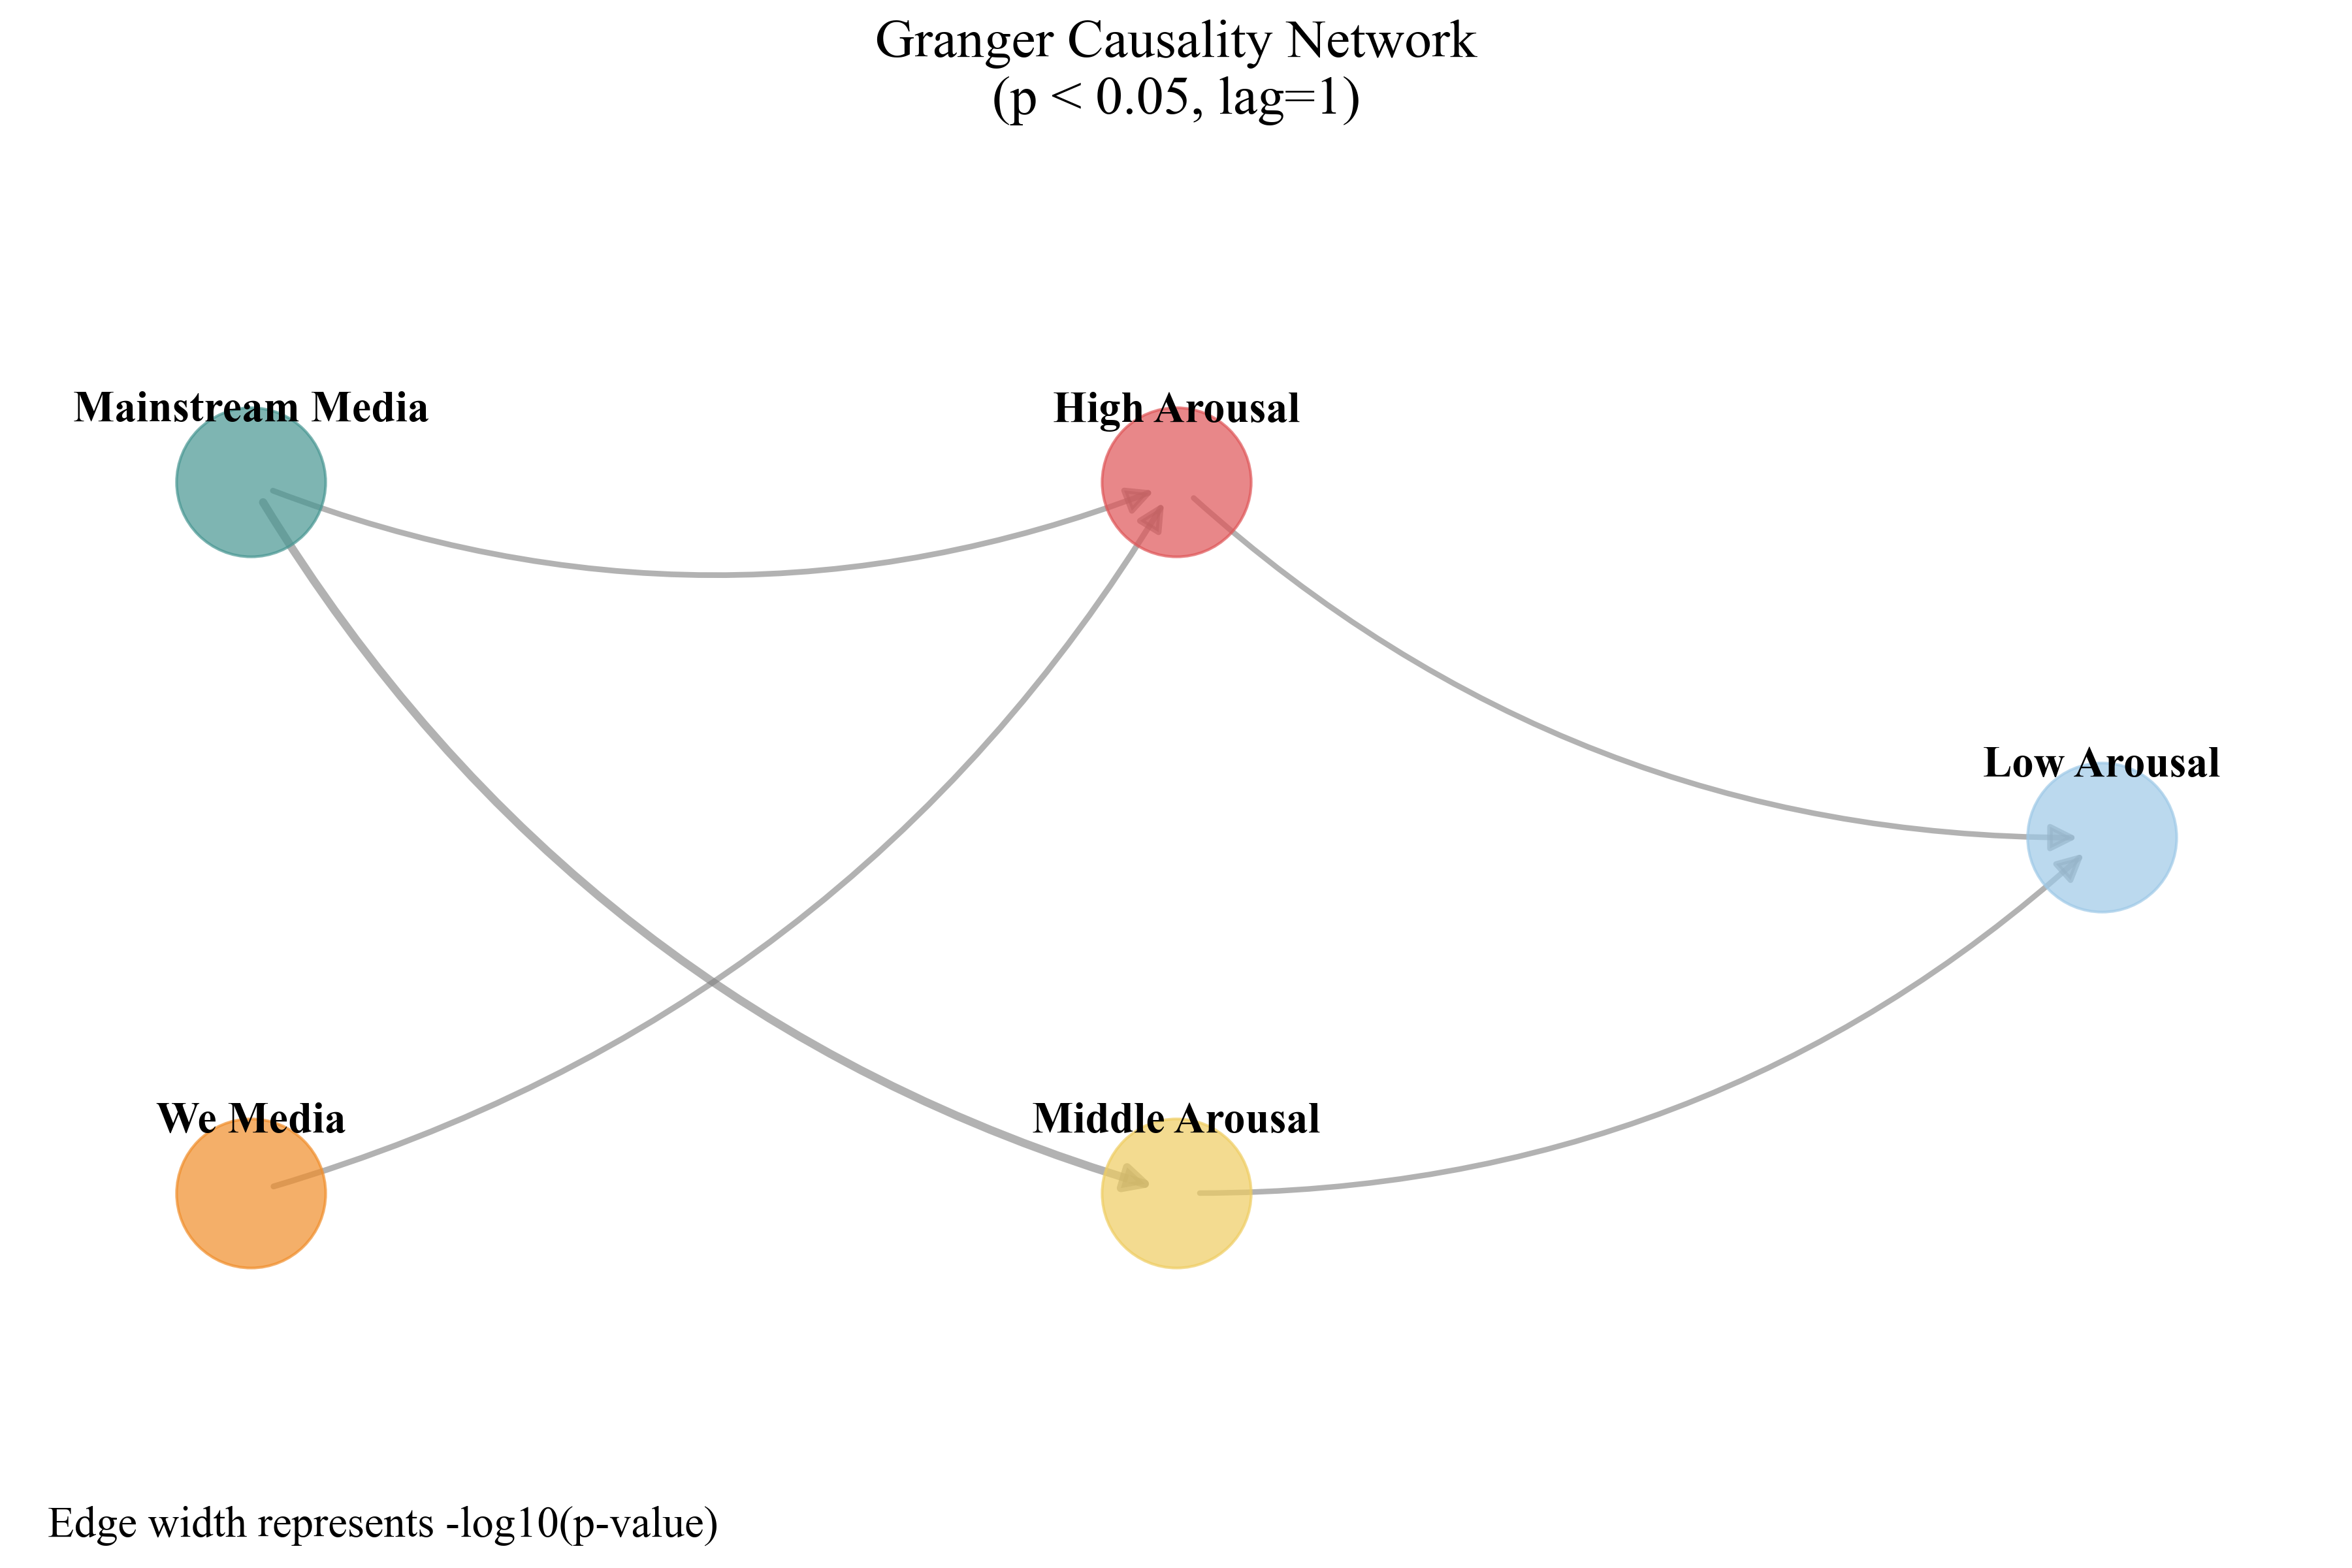

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def create_granger_network(significance_level=0.05):
    # 创建有向图 - 减小图形尺寸
    plt.figure(figsize=(12, 8), dpi=300)  # 从(16, 12)改为(12, 8)
    G = nx.DiGraph()
    
    # 添加节点
    nodes = ['Mainstream Media', 'We Media', 'High Arousal', 'Middle Arousal', 'Low Arousal']
    G.add_nodes_from(nodes)
    
    # 定义显著的因果关系
    edges = [
        ('Mainstream Media', 'High Arousal', 0.023, 5.175),
        ('Mainstream Media', 'Middle Arousal', 0.001, 11.331),
        ('We Media', 'High Arousal', 0.018, 5.603),
        ('High Arousal', 'Low Arousal', 0.028, 4.813),
        ('Middle Arousal', 'Low Arousal', 0.028, 4.813)
    ]
    
    # 添加边
    G.add_weighted_edges_from([(s, t, -np.log10(p)) for s, t, p, _ in edges])
    
    # 优化节点位置
    pos = {
        'Mainstream Media': (-2, 0.5),
        'We Media': (-2, -0.5),
        'High Arousal': (0, 0.5),
        'Middle Arousal': (0, -0.5),
        'Low Arousal': (2, 0)
    }
    
    # 设置节点颜色
    node_colors = {
        'Mainstream Media': '#479692',
        'We Media': '#F08D2A',
        'High Arousal': '#DF5557',
        'Middle Arousal': '#EFCD61',
        'Low Arousal': '#9EC9E7'
    }
    
    # 绘制边（箭头）
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [w/max(edge_weights) * 2 + 1 for w in edge_weights]
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=edge_widths, 
                          alpha=0.6, arrows=True, 
                          arrowsize=20,  # 减小箭头大小
                          connectionstyle='arc3,rad=0.2')
    
    # 绘制节点 - 减小节点大小
    for node in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=node_colors[node],
                             node_size=3000, alpha=0.7)  # 从4000改为3000
    
    # 添加节点标签
    label_pos = {node: (coord[0], coord[1] + 0.1) for node, coord in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=16, font_family='Times New Roman', font_weight='bold')
    
    # 设置标题
    plt.title('Granger Causality Network\n(p < 0.05, lag=1)', 
             fontsize=20, pad=5,  # 减小字体和pad
             fontfamily='Times New Roman')
    plt.axis('off')
    
    # 添加图例说明
    plt.figtext(0.02, 0.02, 'Edge width represents -log10(p-value)', 
                fontsize=16, fontfamily='Times New Roman')
    
    # 调整显示范围
    plt.xlim(-2.5, 2.5)
    plt.ylim(-1, 1)  # 进一步压缩垂直空间
    
    # 使用更紧凑的布局
    plt.tight_layout(pad=0.5)  # 减小pad值
    
    return plt.gcf()

# 创建并显示图形
fig = create_granger_network()
plt.show()

## 整理校准出来的模型参数

In [5]:
import pickle
import pandas as pd
with open('abc_results/abc_results.pkl', 'rb') as f:
    abc_results = pickle.load(f)

In [13]:

# 打印最佳参数
print("\nBest parameters found:")
for param, value in abc_results['best_params'].items():
    print(f"{param}: {value:.4f}")
print(f"Best error: {abc_results['best_error']:.4f}")


Best parameters found:
alpha: 39.6205
beta: 0.8551
theta: 0.0100
sigma: 33.8471
zeta: 0.5703
miu: 0.9374
g_m: 96.8812
Best error: 0.1253
